<a href="https://colab.research.google.com/github/ibrahimzafar/Support-Vector-Machines-and-Cross-Validation/blob/master/Support%20Vector%20Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Support Vector Machines and Cross Validation** 




In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

### Loading the Iris Dataset from sklearn

In [0]:
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target

In [0]:
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-40]]
iris_y_train = iris_y[indices[:-40]]
iris_X_valid = iris_X[indices[-40:-20]]
iris_y_valid = iris_y[indices[-40:-20]]
iris_X_test = iris_X[indices[-20:]]
iris_y_test = iris_y[indices[-20:]]

## **Linear Support Vector Machine Classifier**



Use the validation set (iris_X_valid, iris_y_valid) to identify the optimal value for C, at
least given the validation set.


In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(iris_X)
print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [106]:
params = {}  
for c in np.geomspace(1e-3, 1e3, 7).tolist():

  cumulative = []
  for train_index, val_index in kf.split(iris_X):
 #   print("TRAIN:", len(train_index), "TEST:", len(val_index))
    X_train, X_val = iris_X[train_index], iris_X[val_index]
    y_train, y_val = iris_y[train_index], iris_y[val_index]

    svc = svm.SVC(kernel='linear', C=c, random_state=42)
    svc.fit(X_train, y_train)
    predictions = svc.predict(X_val)
    acc = (predictions == y_val).mean()
    cumulative.append(acc)
  
  params[str(c)] = mean(cumulative)
  print("Value of C: {} \t Avg. Accuracy: {:1f}".format(c, round(mean(cumulative), 4)))

Value of C: 0.001 	 Avg. Accuracy: 0.260000
Value of C: 0.01 	 Avg. Accuracy: 0.406700
Value of C: 0.1 	 Avg. Accuracy: 0.786700
Value of C: 1.0 	 Avg. Accuracy: 0.806700
Value of C: 10.0 	 Avg. Accuracy: 0.800000
Value of C: 100.0 	 Avg. Accuracy: 0.806700
Value of C: 1000.0 	 Avg. Accuracy: 0.806700


### Plotting Avg. Accuracy against Values of C

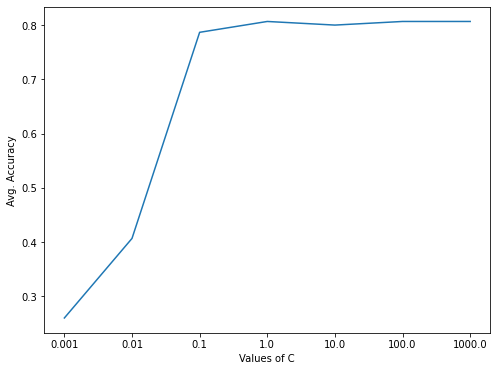

In [111]:
lists = sorted(params.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(8,6))
plt.xlabel('Values of C')
plt.ylabel('Avg. Accuracy')
plt.plot(x, y)
plt.show()

We can see that the best results are at a C value of 1.0.

## **Non-Linear Support Vector Machine Classifier**

### Grid Search for best parameters, using K-Fold Cross Validation

Reference for gamma and C values should ideally be on a geometric series, such as :

'C': np.geomspace(2e-5, 2e15, 11).tolist()

'gamma': np.geomspace(2e-13, 2e3, 17).tolist()

*   https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters
*   https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf






We manually implemented the parameter search in the Linear SVM code above. 

Now we will use GridSearchCV from sklearn that takes care of a Grid Search over all parameters, and performs a K-Fold cross validation for each parameter. 

As done before, k = 5, specified as cv=5 in the model's parameters.

In [112]:
parameters = {'C':np.geomspace(1e-3, 1e3, 7).tolist(), 'gamma': np.geomspace(1e-2, 1e1, 7).tolist()}
svc = svm.SVC(kernel='rbf', random_state=42)

#For the parameter 'cv' with integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
non_linear_clf = GridSearchCV(svc, parameters, refit=True, cv=5, n_jobs=-1, scoring='accuracy')
non_linear_clf.fit(iris_X, iris_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'gamma': [0.01, 0.03162277660168379, 0.1,
                                   0.31622776601683794, 1.0, 3.1622776601683795,
                                   10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## Retrieving the best parameters

In [119]:
optimised_nonlinear_SVM = non_linear_clf.best_estimator_
print(optimised_nonlinear_SVM)
print(non_linear_clf.best_score_)
print(non_linear_clf.best_params_)
best_C = non_linear_clf.best_params_['C']
best_gamma = non_linear_clf.best_params_['gamma']

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.31622776601683794,
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
0.8266666666666668
{'C': 10.0, 'gamma': 0.31622776601683794}


## Plotting the Decision Boundary

In [0]:
def plot_contours(ax, clf, xx, yy, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = ax.contourf(xx, yy, Z, **params)
  return out
def make_meshgrid(x, y, h=.02):
  x_min, x_max = x.min() - 1, x.max() + 1
  y_min, y_max = y.min() - 1, y.max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
  np.arange(y_min, y_max, h))
  return xx, yy

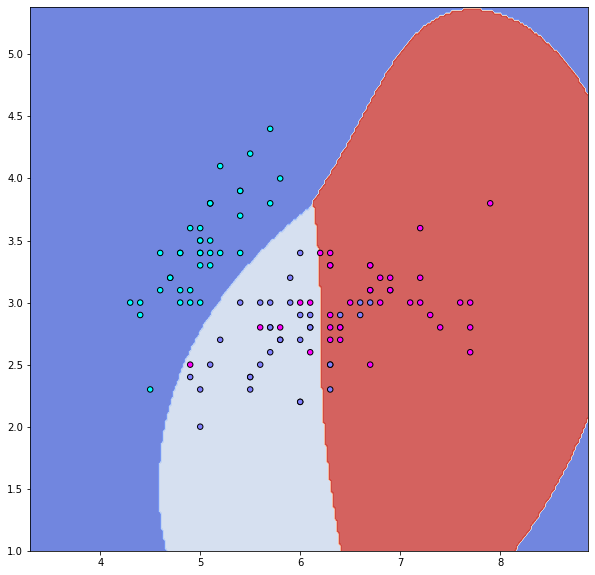

In [137]:
svc = svm.SVC(kernel='rbf', gamma=best_gamma, C=best_C, random_state=42)
pred = svc.fit(iris_X_train, iris_y_train)
U, V = iris_X_train[:, 0], iris_X_train[:, 1]
xx, yy = make_meshgrid(U, V)
figsize = 10
fig = plt.figure(figsize=(figsize,figsize))
ax = plt.subplot(111)
plot_contours(ax, svc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(U, V, c=iris_y_train, cmap=plt.cm.cool, s=30, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())

ax.set_ylim(yy.min(), yy.max())
plt.show()
